# Introduction: Tuning Automated Feature Engineering(応用)

このノートブックでは、ホームクレジットデフォルトリスクコンペティションに適用される[基本的な自動機能エンジニアリング](https://www.kaggle.com/willkoehrsen/applied-automated-feature-engineering-basics)について詳しく説明します。機能のセットを改善し、ドメイン知識を最終的なデータセットに組み込むためのいくつかの異なる方法を検討します。これらの方法は次のとおりです。

* 変数タイプを適切に表す
* 時間変数の作成と使用
* 変数の興味深い値を設定する
* シードフィーチャーの作成
* カスタムプリミティブの構築

この競争に関する議論を読み、いくつかのトップカーネルを調べていくには、複雑な特徴エンジニアリングが必須です。基本的なノートブックでデフォルトの機能プリミティブを使用するとスコアが向上しましたが、それを向上させるには、より高度な方法が必要になります。

これは、完全な実装というよりも、機能ツールの機能の調査としての役割を果たします。私はまだ、他のカーネルを読んで、機能を見つけ、featuretoolsでそれらを再作成して構築する方法を理解することによって、構築するのに最も役立つ機能を理解することに取り組んでいます。どんなアイデアでも大歓迎です！

この作業は、[featuretoolsドキュメント](https://docs.featuretools.com/)と[featuretools GitHubリポジトリ](https://github.com/Featuretools/featuretools)を大いに利用しています。 

In [76]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import woodwork as ww

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings 
warnings.filterwarnings('ignore')

### Read in Data and Create Smaller Datasets

自動化された特徴エンジニアリングは計算量の多い作業であるため、データを1000行に制限します。 後で、このコードを関数にリファクタリングし、スクリプトに入れて、より強力なマシンで実行できます。

In [77]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
app_train = pd.read_csv('./home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
app_test = pd.read_csv('./home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
bureau = pd.read_csv('./home-credit-default-risk/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns = ['index'])
bureau_balance = pd.read_csv('./home-credit-default-risk/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns = ['index'])
cash = pd.read_csv('./home-credit-default-risk./POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
credit = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
previous = pd.read_csv('./home-credit-default-risk/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
installments = pd.read_csv('./home-credit-default-risk/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,NaN,0,112500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
1,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,279720.0,0.0,0.0,0.0,Consumer credit,-155,0.0
2,100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,NaN,0,91620.0,0.0,0.0,0.0,Consumer credit,-155,0.0
3,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
4,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.0,113166.0,0.0,0.0,Consumer credit,-6,4630.5


### init woodwork

In [79]:
import woodwork as ww
app_train.ww.init(name='app_train'
    ,index = 'SK_ID_CURR')
app_test.ww.init(name='app_test'
    ,index = 'SK_ID_CURR')
bureau.ww.init(name='bureau'
    ,index = 'SK_ID_BUREAU')
bureau_balance.ww.init(name='bureau_balance')
cash.ww.init(name='cash')
credit.ww.init(name='credit')
previous.ww.init(name='previous'
    ,index = 'SK_ID_PREV')
installments.ww.init(name='installments')
app_train.ww

,Physical Type,Logical Type,Semantic Tag(s)
Column,,,
SK_ID_CURR,int64,Integer,['index']
TARGET,int64,Integer,['numeric']
NAME_CONTRACT_TYPE,category,Categorical,['category']
CODE_GENDER,category,Categorical,['category']
FLAG_OWN_CAR,category,Categorical,['category']
FLAG_OWN_REALTY,category,Categorical,['category']
CNT_CHILDREN,int64,Integer,['numeric']
AMT_INCOME_TOTAL,float64,Double,['numeric']
AMT_CREDIT,float64,Double,['numeric']


# Properly Representing Variable Types

`app`データフレームには整数として表される列がいくつかありますが、実際には限られた数の機能しか引き受けられない離散変数です。 これらの一部はブールフラグ（1または0のみ）であり、2つの列は序数（離散順序）です。 これらをブール変数として扱うようにfeaturetoolsに指示するには、ディクショナリマッピング{`variable_name`：`variable_type`}を使用して正しいデータ型を渡す必要があります。

In [81]:
## https://featuretools.alteryx.com/en/stable/resources/transition_to_ft_v1.0.html?highlight=variable_types#Accessing-column-typing-information
## https://woodwork.alteryx.com/en/stable/start.html

app_types = {}
boolean_columns = []

# Iterate through the columns and record the Boolean columns
for col in app_train:
    #If column is a number with only two values, encode it as a Boolean
    if (app_train[col].dtype != 'Object') and (len(app_train[col].unique()) <= 2):
        app_train.ww.set_types(logical_types={col: 'Boolean'})
        if col != 'TARGET':
            app_test.ww.set_types(logical_types={col: 'Boolean'})
        
        
app_train.ww

,Physical Type,Logical Type,Semantic Tag(s)
Column,,,
SK_ID_CURR,int64,Integer,['index']
TARGET,bool,Boolean,[]
NAME_CONTRACT_TYPE,bool,Boolean,[]
CODE_GENDER,bool,Boolean,[]
FLAG_OWN_CAR,bool,Boolean,[]
FLAG_OWN_REALTY,bool,Boolean,[]
CNT_CHILDREN,int64,Integer,['numeric']
AMT_INCOME_TOTAL,float64,Double,['numeric']
AMT_CREDIT,float64,Double,['numeric']


`app`データには、都市がある場合とない場合の地域の評価という2つの順序変数もあります。

In [82]:
# Record ordinal variables
app_train.ww.set_types(logical_types={'REGION_RATING_CLIENT': 'Boolean'})
app_test.ww.set_types(logical_types={'REGION_RATING_CLIENT': 'Boolean'})
app_train.ww.set_types(logical_types={'REGION_RATING_CLIENT_W_CITY': 'Boolean'})
app_test.ww.set_types(logical_types={'REGION_RATING_CLIENT_W_CITY': 'Boolean'})
app_train.ww

,Physical Type,Logical Type,Semantic Tag(s)
Column,,,
SK_ID_CURR,int64,Integer,['index']
TARGET,bool,Boolean,[]
NAME_CONTRACT_TYPE,bool,Boolean,[]
CODE_GENDER,bool,Boolean,[]
FLAG_OWN_CAR,bool,Boolean,[]
FLAG_OWN_REALTY,bool,Boolean,[]
CNT_CHILDREN,int64,Integer,['numeric']
AMT_INCOME_TOTAL,float64,Double,['numeric']
AMT_CREDIT,float64,Double,['numeric']


前のデータにも2つのブール変数があります。

In [83]:
# Record boolean variables in the previous data
previous.ww.set_types(logical_types={'NFLAG_LAST_APPL_IN_DAY': 'Boolean'})
previous.ww.set_types(logical_types={'NFLAG_INSURED_ON_APPROVAL': 'Boolean'})
previous.ww

,Physical Type,Logical Type,Semantic Tag(s)
Column,,,
SK_ID_PREV,int64,Integer,['index']
SK_ID_CURR,int64,Integer,['numeric']
NAME_CONTRACT_TYPE,category,Categorical,['category']
AMT_ANNUITY,float64,Double,['numeric']
AMT_APPLICATION,float64,Double,['numeric']
AMT_CREDIT,float64,Double,['numeric']
AMT_DOWN_PAYMENT,float64,Double,['numeric']
AMT_GOODS_PRICE,float64,Double,['numeric']
WEEKDAY_APPR_PROCESS_START,category,Categorical,['category']


# Time Variables

動作は時間とともに変化するため、多くのデータセットでは時間が重要な要素になる可能性があります。そのため、これを反映する機能を作成する必要があります。たとえば、クライアントが時間の経過とともにますます多くのローンを借りている可能性があります。これは、デフォルトが発生しそうなことを示している可能性があります。

データには明示的な日時はありませんが、相対的な時間オフセットがあります。すべての時間オフセットは、ホームクレジットの現在のアプリケーションから測定され、月または日で測定されます。たとえば、 `bureau`の`DAYS_CREDIT`列は、「現在の申請の何日前にクライアントが信用調査機関の信用を申請したか」を表します。 （信用調査機関とは、ホームクレジット以外のクレジット組織を指します）。実際の申請日はわかりませんが、すべてのクライアントで同じ開始申請日を想定すれば、`MONTHS_BALANCE`を日時に変換することができます。これは、傾向を見つけたり、変数の最新の値を識別したりするために使用できる相対時間として扱うことができます。

### Replace Outliers

365243として記録される日オフセットがいくつかあります。ディスカッションを読んで、他の人はこの数を`np.nan`に置き換えました。 これを行わないと、Pandasはタイムデルタに変換できず、数値が大きすぎるというエラーがスローされます。 次のコードは、[GitHub](https://github.com/JYLFamily/Home_Credit_Default_Risk/blob/master/20180603/FeaturesV2/ApplicationTestFeatures.py)のスクリプトから変更されています。

In [84]:
import re

def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

# Replace all the day outliers
app_train = replace_day_outliers(app_train)
app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
cash = replace_day_outliers(cash)
previous = replace_day_outliers(previous)
installments = replace_day_outliers(installments)
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
100002,100002,True,True,True,True,True,0,202500.0,406597.5,24700.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0
100003,100003,False,True,True,True,True,0,270000.0,1293502.5,35698.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
100004,100004,False,True,True,True,True,0,67500.0,135000.0,6750.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
100006,100006,False,True,True,True,True,0,135000.0,312682.5,29686.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
100007,100007,False,True,True,True,True,0,121500.0,513000.0,21865.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0


First we can establish an arbitrary date and then convert the time offset in months into a Pandas `timedelta` object. 

In [85]:
# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2016-01-01")
start_date

Timestamp('2016-01-01 00:00:00')

In [86]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
5896630,-857 days,-492 days,-553 days,-155 days
5896631,-909 days,-179 days,-877 days,-155 days
5896632,-879 days,-514 days,-544 days,-155 days
5896633,-1572 days,-1329 days,-1328 days,-155 days
5896634,-559 days,902 days,NaT,-6 days


これらの4つの列は、異なるオフセットを表します。

* `DAYS_CREDIT`：ホームクレジットクライアントでの現在の申請が他の金融機関でのローンを申請するまでの日数。これを申請日`bureau_credit_application_date`と呼び、エンティティの`time_index`にします。
* `DAYS_CREDIT_ENDDATE`：ホームクレジットでのクライアントの申し込み時に残っているクレジットの日数。これを終了日と呼びます`bureau_credit_end_date`
* `DAYS_ENDDATE_FACT`：クローズドクレジットの場合、他の金融機関でのクレジットが終了したホームクレジットでの現在の申請までの日数。これを締め切り日`bureau_credit_close_date`と呼びます。
* `DAYS_CREDIT_UPDATE`：ホームクレジットでの現在の申請の前に、前のクレジットに関する最新の情報が到着した日数。これを更新日`bureau_credit_update_date`と呼びます。

手動の特徴エンジニアリングを行っている場合は、「DAYS_CREDIT」から「DAYS_CREDIT_ENDDATE」を減算してローンの計画期間を日数で取得したり、「DAYS_ENDDATE_FACT」から「DAYS_CREDIT_ENDDATE」を減算して数値を取得したりするなど、新しい列を作成できます。クライアントがローンを早期に完済した日数。ただし、このノートブックでは、手作業で機能を作成するのではなく、featuretoolsに便利な機能を開発させます。

`timedelta`から日付列を作成するには、開始日にオフセットを追加するだけです。

In [87]:
# Create the date columns
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']

### Plot for a sanity check

To make sure the conversion went as planned, let's make a plot showing the distribution of loan lengths.

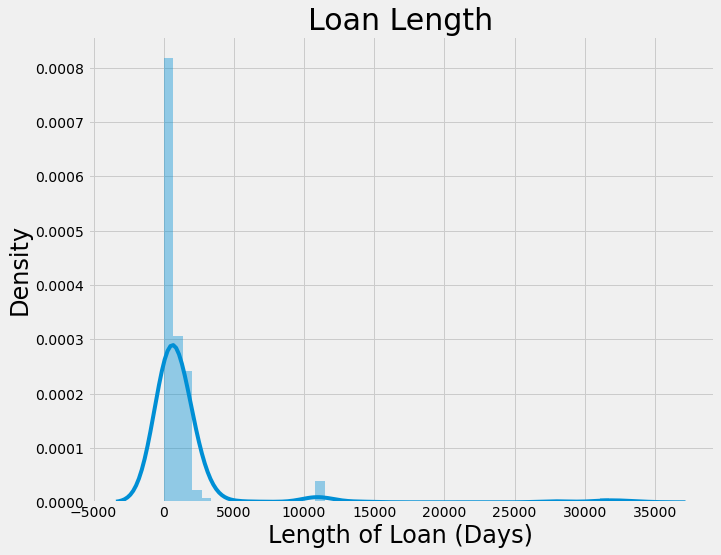

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up default plot styles
plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

# Drop the time offset columns
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size = 24); plt.ylabel('Density', size = 24); plt.title('Loan Length', size = 30);

不当に長いローンがたくさんあるように見えます。 議論を読んで、他の人々もこれに気づいていました。 この時点で、外れ値を残します。 また、タイムオフセット列も削除します。

#### Bureau Balance

局の残高データフレームには、月のオフセットとして使用できる`MONTHS_BALANCE`列があります。 結果の日付の列は、`time_index`として使用できます。

[pandas.to_timedelta](https://pandas.pydata.org/docs/reference/api/pandas.to_timedelta.html)

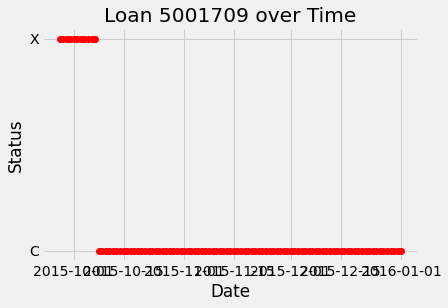

In [89]:
# Convert to timedelta
bureau_balance['MONTHS_BALANCE'] = pd.to_timedelta(bureau_balance['MONTHS_BALANCE'], 'D')

# Make a date column
bureau_balance['bureau_balance_date'] = start_date + bureau_balance['MONTHS_BALANCE']
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

# Select one loan and plot
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro');
plt.title('Loan 5001709 over Time'); plt.xlabel('Date'); plt.ylabel('Status');

#### Previous Applications

`previous`データフレームは、HomeCreditで以前のアプリケーションを保持します。 このデータセットには、いくつかの時間オフセット列があります。

* `DAYS_DECISION`：ホームクレジットでの現在の申請の前に、以前の申請について決定が下された日数。 これは、データの`time_index`になります。
* `DAYS_FIRST_DRAWING`：最初の支払いが行われたホームクレジットでの現在の申請までの日数
* `DAYS_FIRST_DUE`：ホームクレジットでの現在の申請までの日数。
* `DAYS_LAST_DUE_1ST_VERSION`：ホームクレジットでの現在の申請の最初の日数??
* `DAYS_LAST_DUE`：前回の申請の最終期日のホームクレジットでの現在の申請までの日数
* `DAYS_TERMINATION`：ホームクレジットでの現在の申請までの日数

これらすべてをループ内のタイムデルタに変換してから、時間列を作成しましょう。

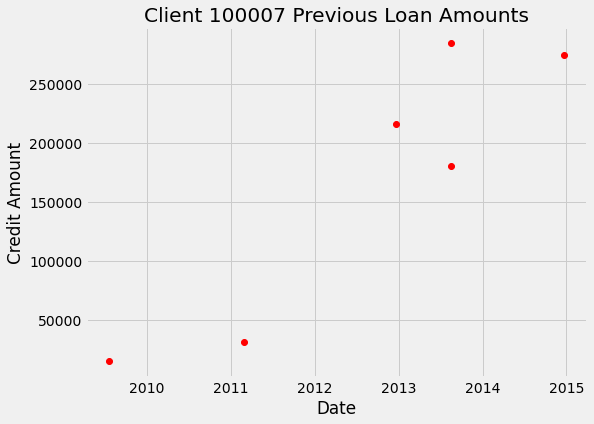

In [90]:
# Convert to timedeltas in days
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    previous[col] = pd.to_timedelta(previous[col], 'D')
    
# Make date columns
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

# Drop the time offset columns
previous = previous.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])

plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100007]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100007 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');

#### Previous Credit and Cash

`credit_card_balance`と`POS_CASH_balance`には、それぞれ月がオフセットされた`MONTHS_BALANCE`列があります。 これは、前の申請レコードのホームクレジットでの現在の申請までの月数です。 これらは、データの`time_index`を表します。

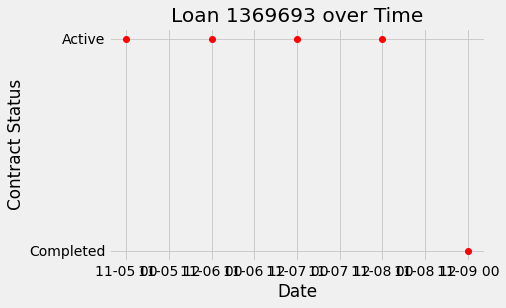

In [91]:
# Convert to timedelta objects
credit['MONTHS_BALANCE'] = pd.to_timedelta(credit['MONTHS_BALANCE'], 'D')
cash['MONTHS_BALANCE'] = pd.to_timedelta(cash['MONTHS_BALANCE'], 'D')

# Make a date column
credit['credit_balance_date'] = start_date + credit['MONTHS_BALANCE']
credit = credit.drop(columns = ['MONTHS_BALANCE'])

# Make a date column
cash['cash_balance_date'] = start_date + cash['MONTHS_BALANCE']
cash = cash.drop(columns = ['MONTHS_BALANCE'])

# Select on loan and plot
example_credit = cash[cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro');
plt.title('Loan 1369693 over Time'); plt.xlabel('Date'); plt.ylabel('Contract Status');

#### Installments Payments 

`installments_payments`データには、ホームクレジットでの以前のローンで行われた各支払いに関する情報が含まれています。 2つの日付オフセット列があります。

* `DAYS_INSTALMENT`：ホームクレジットでの現在の申請の前に、前の分割払いが支払われることになっていた日数
* `DAYS_ENTRY_PAYMENT`：ホームクレジットでの現在の申請の前に、前の分割払いが実際に支払われた日数

これで、プロセスはおなじみのはずです。timedeltaに変換してから、時間列を作成します。 DAYS_INSTALMENTは`time_index`として機能します。

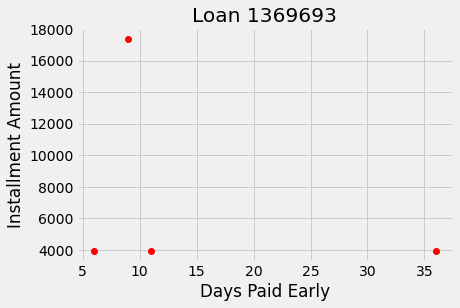

In [92]:
# Conver to time delta object
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

# Select one loan and plot
example_credit = installments[installments['SK_ID_PREV'] == 1369693]
plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');

# Applying Featuretools

これで、時間列を使用してフィーチャの作成を開始できます。 以前と同じようにclientsという名前のエンティティセットを作成しますが、使用できる時間変数ができました。

In [93]:
# Make an entityset
es = ft.EntitySet(id = 'clients')

### Entities

エンティティを作成するときに、 `index`、` time_index`（存在する場合）、および `variable_types`（指定する必要がある場合）を指定します。

In [94]:
# Entities with a unique index
es = es.add_dataframe(dataframe_name = 'app_train'
                    ,dataframe = app_train
                    ,index = 'SK_ID_CURR')

es = es.add_dataframe(dataframe_name = 'app_test'
                    ,dataframe = app_test
                    ,index = 'SK_ID_CURR')

es = es.add_dataframe(dataframe_name = 'bureau'
                              ,dataframe = bureau
                              ,index = 'SK_ID_BUREAU'
                              ,time_index='bureau_credit_application_date')

es = es.add_dataframe(dataframe_name = 'previous'
                              ,dataframe = previous
                              ,index = 'SK_ID_PREV'
                              ,time_index = 'previous_decision_date')

# Entities that do not have a unique index
es = es.add_dataframe(dataframe_name = 'bureau_balance'
                              ,dataframe = bureau_balance
                              ,make_index = True
                              ,index = 'bb_index'
                              ,time_index = 'bureau_balance_date')

es = es.add_dataframe(dataframe_name = 'cash'
                              ,dataframe = cash
                              ,make_index = True
                              ,index = 'cash_index'
                              ,time_index = 'cash_balance_date')

es = es.add_dataframe(dataframe_name = 'installments'
                              ,dataframe = installments
                              ,make_index = True
                              ,index = 'installments_index'
                              ,time_index = 'installments_paid_date')

es = es.add_dataframe(dataframe_name = 'credit'
                              ,dataframe = credit
                              ,make_index = True
                              ,index = 'credit_index'
                              ,time_index = 'credit_balance_date')
es

Entityset: clients
  DataFrames:
    app_train [Rows: 1001, Columns: 122]
    app_test [Rows: 1001, Columns: 121]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    No relationships

### Relationships

当然のことながら、テーブル間の関係は以前の実装から変更されていません。

In [95]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es, 'app_train', 'SK_ID_CURR', 'bureau', 'SK_ID_CURR')

# Test Relationship between app and bureau
r_test_app_bureau = ft.Relationship(es, 'app_test', 'SK_ID_CURR', 'bureau', 'SK_ID_CURR')

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es, 'bureau', 'SK_ID_BUREAU', 'bureau_balance', 'SK_ID_BUREAU')

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es, 'app_train', 'SK_ID_CURR', 'previous', 'SK_ID_CURR')

# Test Relationship between current app and previous apps
r_test_app_previous = ft.Relationship(es, 'app_test', 'SK_ID_CURR', 'previous', 'SK_ID_CURR')

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es, 'previous', 'SK_ID_PREV', 'cash', 'SK_ID_PREV')
r_previous_installments = ft.Relationship(es, 'previous', 'SK_ID_PREV', 'installments', 'SK_ID_PREV')
r_previous_credit = ft.Relationship(es, 'previous', 'SK_ID_PREV', 'credit', 'SK_ID_PREV')

# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_test_app_bureau, r_bureau_balance, r_app_previous, r_test_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  DataFrames:
    app_train [Rows: 1001, Columns: 122]
    app_test [Rows: 1001, Columns: 121]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app_train.SK_ID_CURR
    bureau.SK_ID_CURR -> app_test.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app_train.SK_ID_CURR
    previous.SK_ID_CURR -> app_test.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

## Time Features

新しい時間変数から作成できる時間機能のいくつかを見てみましょう。 これらの時間は相対的なものであり、絶対的なものではないため、傾向や累積合計など、時間の経過に伴う変化を示す値にのみ関心があります。 任意の開始日を選択するため、年や月などの値は計算したくありません。

このノートブック全体で、 `chunk_size`を`dfs`呼び出しに渡します。これは、行数（整数の場合）または各チャンクで使用する1つまたは複数の行（floatの場合）を指定します。 これは`dfs`プロシージャを最適化するのに役立ち、 `chunk_size`は[実行時間に大きな影響を与える](https://docs.featuretools.com/guides/performance.html)可能性があります。 ここでは、データの行数に等しいチャンクサイズを使用して、すべての結果が1回のパスで計算されるようにします。 また、テストデータを使用して機能を作成することは避けたいので、 `ignore_entities=[app_test]`を渡します。

In [96]:
time_features, time_feature_names = ft.dfs(entityset = es
                                           ,target_dataframe_name = 'app_train'
                                           ,trans_primitives = ['cum_sum', 'time_since_previous']
                                           ,max_depth = 2
                                           ,agg_primitives = ['trend']
                                           ,features_only = False, verbose = True
                                           ,chunk_size = len(app_train)
                                           ,ignore_dataframes = ['app_test'])

Built 452 features
Elapsed: 00:15 | Progress: 100%|██████████


In [97]:
time_features.iloc[:, -10:].head()

,"CUM_SUM(TREND(previous.AMT_APPLICATION, previous_decision_date))","CUM_SUM(TREND(previous.AMT_CREDIT, previous_decision_date))","CUM_SUM(TREND(previous.AMT_DOWN_PAYMENT, previous_decision_date))","CUM_SUM(TREND(previous.AMT_GOODS_PRICE, previous_decision_date))","CUM_SUM(TREND(previous.CNT_PAYMENT, previous_decision_date))","CUM_SUM(TREND(previous.HOUR_APPR_PROCESS_START, previous_decision_date))","CUM_SUM(TREND(previous.RATE_DOWN_PAYMENT, previous_decision_date))","CUM_SUM(TREND(previous.RATE_INTEREST_PRIMARY, previous_decision_date))","CUM_SUM(TREND(previous.RATE_INTEREST_PRIVILEGED, previous_decision_date))","CUM_SUM(TREND(previous.SELLERPLACE_AREA, previous_decision_date))"
SK_ID_CURR,,,,,,,,,,
100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,367.444774,418.305454,NaN,367.444774,-0.001774,-0.000448,NaN,NaN,NaN,0.285154
100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,630.070715,776.928357,NaN,1391.162781,0.045124,0.002063,NaN,NaN,NaN,-1.333402
100007,762.957307,928.679814,NaN,1524.049373,0.055780,0.000891,NaN,NaN,NaN,-1.706613


これらの新しい変数の1つを視覚化してみましょう。 時間の経過に伴うクレジットサイズの傾向を見ることができます。 正の値は、クライアントのローンサイズが時間の経過とともに増加していることを示します。 

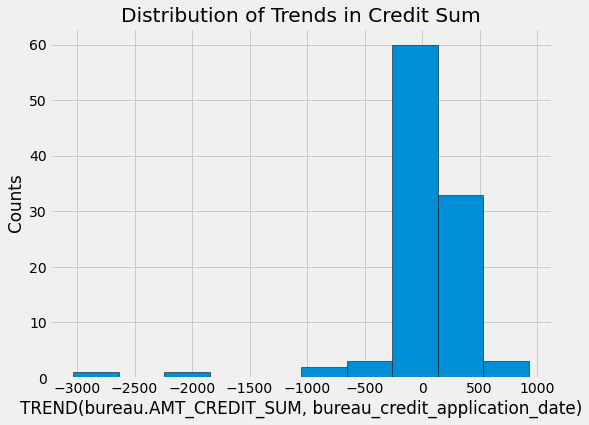

In [98]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Credit Sum');

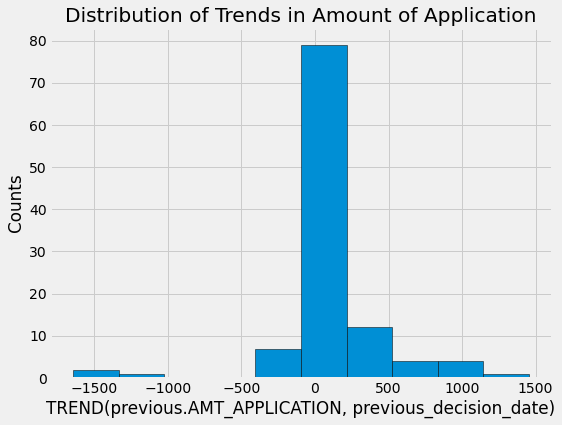

In [99]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(previous.AMT_APPLICATION, previous_decision_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(previous.AMT_APPLICATION, previous_decision_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Amount of Application');

In [100]:
time_feature_names[-10:]

[<Feature: CUM_SUM(TREND(previous.AMT_APPLICATION, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_CREDIT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_DOWN_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_GOODS_PRICE, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.CNT_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.HOUR_APPR_PROCESS_START, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_DOWN_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_INTEREST_PRIMARY, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_INTEREST_PRIVILEGED, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.SELLERPLACE_AREA, previous_decision_date))>]

# Interesting Values

featuretoolsで使用できるもう1つの方法は、「興味深い値」です。 興味深い値を指定すると、既存の機能の値を条件として新しい機能が計算されます。 たとえば、`previous`データフレームの`NAME_CONTRACT_STATUS`の値を条件とする新しい機能を作成できます。 各統計は、指定された興味深い値に対して計算されます。これは、データでより重要な特定の指標があることがわかっている場合に役立ちます。 

In [101]:
previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: NAME_CONTRACT_STATUS, dtype: int64

To use interesting values, we assign them to the variable and then specify the `where_primitives` in the `dfs` call. 

In [102]:
interesting_features.iloc[:, -6:, ].head()

,SUM(previous.HOUR_APPR_PROCESS_START),SUM(previous.NFLAG_INSURED_ON_APPROVAL),SUM(previous.RATE_DOWN_PAYMENT),SUM(previous.RATE_INTEREST_PRIMARY),SUM(previous.RATE_INTEREST_PRIVILEGED),SUM(previous.SELLERPLACE_AREA)
SK_ID_CURR,,,,,,
100002,9.0,0.0,0.000000,0.0,0.0,500.0
100003,44.0,2.0,0.100061,0.0,0.0,1599.0
100004,5.0,0.0,0.212008,0.0,0.0,30.0
100006,132.0,0.0,0.326824,0.0,0.0,8048.0
100007,74.0,3.0,0.319033,0.0,0.0,2455.0


機能の1つは、 `MEAN（previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved）`です。 これは、前のローンが承認されることを条件とした前のローンの平均「前のクレジットの期間」を示しています。 この機能の分布を`MEAN（previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Cancelled）`と比較して、これらのローンの違いを確認できます。

In [103]:
# Assign interesting values
es['previous']['NAME_CONTRACT_STATUS'].interesting_values = ['Approved', 'Refused', 'Canceled']

# Calculate the features with intereseting values
interesting_features, interesting_feature_names = ft.dfs(entityset=es
                                                         ,target_dataframe_name='app_train'
                                                         ,max_depth = 1
                                                         ,where_primitives = ['mean', 'mode']
                                                         ,trans_primitives=[]
                                                         ,features_only = False
                                                         ,verbose = True
                                                         ,chunk_size = len(app_train)
                                                         ,ignore_dataframes = ['app_test'])

Built 277 features
Elapsed: 00:00 | Progress: 100%|██████████


In [104]:
interesting_feature_names

[<Feature: TARGET>,
 <Feature: NAME_CONTRACT_TYPE>,
 <Feature: CODE_GENDER>,
 <Feature: FLAG_OWN_CAR>,
 <Feature: FLAG_OWN_REALTY>,
 <Feature: CNT_CHILDREN>,
 <Feature: AMT_INCOME_TOTAL>,
 <Feature: AMT_CREDIT>,
 <Feature: AMT_ANNUITY>,
 <Feature: AMT_GOODS_PRICE>,
 <Feature: NAME_TYPE_SUITE>,
 <Feature: NAME_INCOME_TYPE>,
 <Feature: NAME_EDUCATION_TYPE>,
 <Feature: NAME_FAMILY_STATUS>,
 <Feature: NAME_HOUSING_TYPE>,
 <Feature: REGION_POPULATION_RELATIVE>,
 <Feature: DAYS_BIRTH>,
 <Feature: DAYS_EMPLOYED>,
 <Feature: DAYS_REGISTRATION>,
 <Feature: DAYS_ID_PUBLISH>,
 <Feature: OWN_CAR_AGE>,
 <Feature: FLAG_MOBIL>,
 <Feature: FLAG_EMP_PHONE>,
 <Feature: FLAG_WORK_PHONE>,
 <Feature: FLAG_CONT_MOBILE>,
 <Feature: FLAG_PHONE>,
 <Feature: FLAG_EMAIL>,
 <Feature: OCCUPATION_TYPE>,
 <Feature: CNT_FAM_MEMBERS>,
 <Feature: REGION_RATING_CLIENT>,
 <Feature: REGION_RATING_CLIENT_W_CITY>,
 <Feature: WEEKDAY_APPR_PROCESS_START>,
 <Feature: HOUR_APPR_PROCESS_START>,
 <Feature: REG_REGION_NOT_LIVE_REG

In [105]:
type(interesting_features)

pandas.core.frame.DataFrame

In [106]:
interesting_features['MODE(previous.NAME_CONTRACT_STATUS)'].dropna()

SK_ID_CURR
100002    Approved
100003    Approved
100004    Approved
100006    Approved
100007    Approved
            ...   
100197    Approved
100198    Approved
100199    Approved
100200    Approved
100201    Approved
Name: MODE(previous.NAME_CONTRACT_STATUS), Length: 162, dtype: category
Categories (3, object): ['Approved', 'Canceled', 'Refused']

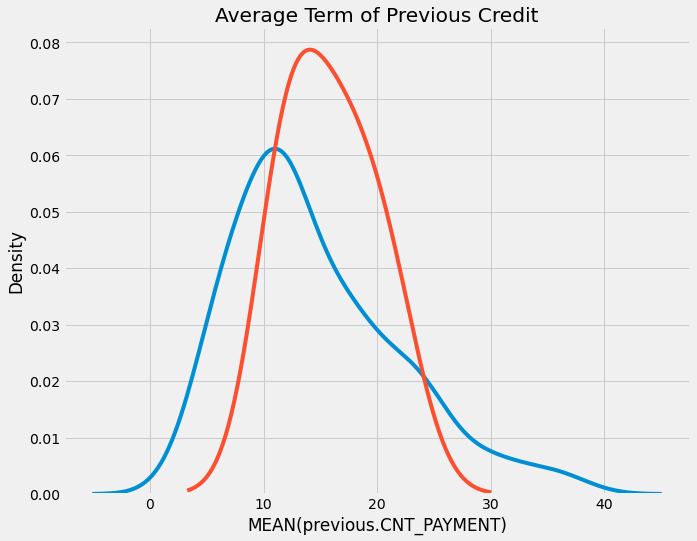

In [107]:
plt.figure(figsize = (10, 8))
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT)'].where(interesting_features['MODE(previous.NAME_CONTRACT_STATUS)'] == 'Approved').dropna(), label = 'Approved')
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT)'].where(interesting_features['MODE(previous.NAME_CONTRACT_STATUS)'] == 'Canceled').dropna(), label = 'Canceled')
plt.xlabel('MEAN(previous.CNT_PAYMENT)'); plt.ylabel('Density'); plt.title('Average Term of Previous Credit');

In [108]:
interesting_features['MODE(previous.NAME_CLIENT_TYPE)'].where(interesting_features['MODE(previous.NAME_CONTRACT_STATUS)'] == 'Approved')

SK_ID_CURR
100002          New
100003    Refreshed
100004          New
100006     Repeater
100007     Repeater
            ...    
101153          NaN
101154          NaN
101155          NaN
101156          NaN
101157          NaN
Name: MODE(previous.NAME_CLIENT_TYPE), Length: 1001, dtype: category
Categories (4, object): ['New', 'Refreshed', 'Repeater', 'XNA']

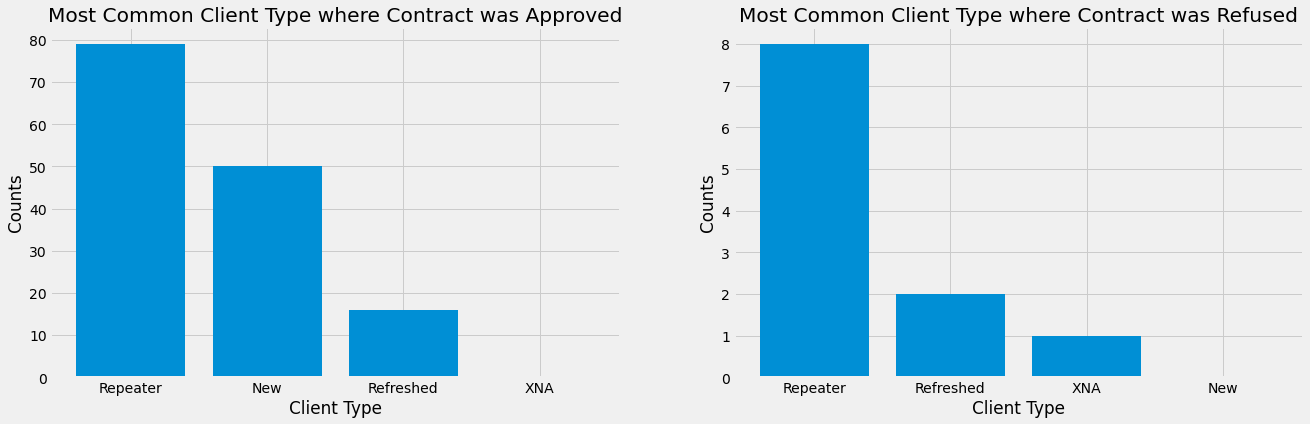

In [109]:
# Plot of client type when contract was approved
plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.bar(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE)'].where(interesting_features['MODE(previous.NAME_CONTRACT_STATUS)'] == 'Approved').value_counts())
plt.xticks(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE)'].where(interesting_features['MODE(previous.NAME_CONTRACT_STATUS)'] == 'Approved').value_counts().index)



plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Approved");

# Plot of client type where contract was refused
plt.subplot(1, 2, 2)
plt.bar(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE)'].where(interesting_features['MODE(previous.NAME_CONTRACT_STATUS)'] == 'Refused').value_counts())
plt.xticks(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE)'].where(interesting_features['MODE(previous.NAME_CONTRACT_STATUS)'] == 'Refused').value_counts().index)
plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Refused");

In [110]:
es['installments']['installments_due_date']

4     2008-01-07
198   2008-01-15
651   2008-01-21
199   2008-02-14
648   2008-02-20
         ...    
931   2015-12-05
692   2015-12-21
88    2015-12-18
527   2015-12-18
70    2015-12-21
Name: installments_due_date, Length: 1001, dtype: datetime64[ns]

In [111]:
# Late Payment seed feature
late_payment = ft.Feature(es['installments'].ww['installments_due_date']) < ft.Feature(es['installments'].ww['installments_paid_date'])

# Rename the feature
late_payment = late_payment.rename("late_payment")

# DFS with seed features
seed_features, seed_feature_names = ft.dfs(entityset = es
                                           ,target_dataframe_name = 'app_train'
                                           ,agg_primitives = ['percent_true', 'mean']
                                           ,trans_primitives = []
                                           ,seed_features = [late_payment]
                                           ,features_only = False
                                           ,verbose = True
                                           ,chunk_size = len(app_train)
                                           ,ignore_dataframes = ['app_test'])

Built 251 features
Elapsed: 00:00 | Progress: 100%|██████████


Based on the most important features returned by a model, we can create new interesting features. This is one area where we can apply domain knowledge to feature creation.

# Seed Features

デフォルトの集計と変換の追加の拡張機能は、[シード機能](https://docs.featuretools.com/automated_feature_engineering/dfs_usage_tips.html#specifying-list-of-aggregation-functions)を使用することです。 これらはユーザー定義の機能であり、可能な場合はその上に構築できる詳細な機能合成に提供されます。

例として、支払いが遅れたかどうかを判断するシード機能を作成できます。 今回は`dfs`関数呼び出しを行うときに、`seed_features`引数を渡す必要があります。

In [112]:
seed_features.iloc[:, -2:].head(10)

,PERCENT_TRUE(credit.previous.NFLAG_LAST_APPL_IN_DAY),MEAN(previous.PERCENT_TRUE(installments.late_payment))
SK_ID_CURR,,
100002,0.0,0.000000
100003,0.0,0.000000
100004,0.0,0.000000
100006,1.0,0.000000
100007,0.0,0.239927
100008,0.0,0.018182
100009,0.0,0.000000
100010,0.0,0.000000
100011,1.0,0.207870


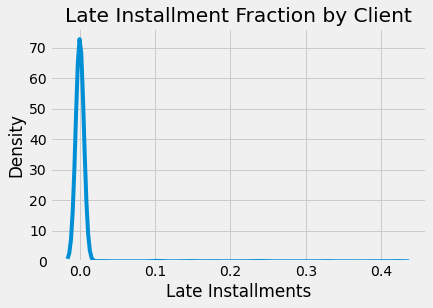

In [113]:
sns.kdeplot(seed_features['PERCENT_TRUE(installments.late_payment)'].dropna(), label = '')
plt.xlabel('Late Installments'); plt.ylabel('Density'); plt.title('Late Installment Fraction by Client');

使用できるもう1つのシード機能は、別の機関での以前のローンの期限が過ぎているかどうかです。

In [114]:
# Create a feed representing whether the loan is past due
past_due = ft.Feature(es['bureau_balance']['STATUS']).isin(['1', '2', '3', '4', '5'])
past_due = past_due.rename("past_due")

In [115]:
# DFS with specified seed feature
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_dataframe_name = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [past_due],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_dataframes = ['app_test'])

Built 251 features
Elapsed: 00:00 | Progress: 100%|██████████


# Create Custom Feature Primitives

featuretoolsの既存のプリミティブに満足できない場合は、[独自に作成できます](https://docs.featuretools.com/automated_feature_engineering/primitives.html#defining-custom-primitives). これは、featuretoolの機能を拡張できる非常に強力な方法です。s. 

### NormalizedModeCount and LongestSeq

例として、[featuretools GitHub](https://github.com/Featuretools/featuretools)のコードに基づいて3つの機能を作成します。これらは集計プリミティブになり、関数は値の配列を受け取り、単一の値を返します。最初の`NormalizedModeCount`は、モデルが構成するカテゴリ機能の全観測値の割合を返すことにより、`Mode`関数に基づいて構築されています。つまり、`STATUS`の4つが`X`である合計5つの`bureau_balance`観測値を持つクライアントの場合、`NormalizedModeCount`の値は0.8になります。アイデアは、最も一般的な値だけでなく、すべての観測値と比較した最も一般的な値の相対度数も記録することです。

2番目のカスタム機能は、離散変数の最長連続実行を記録します。 `LongestSeq`は離散値の配列を受け取り、最も連続して出現する要素を返します。エンティティセット内のエンティティは`time_index`で並べ替えられるため、これにより、時間に対して連続して最も多く発生する値が返されます。

現行バージョンでの集計プリミティブ定義について[Simple Custom Primitives](https://featuretools.alteryx.com/en/stable/getting_started/primitives.html?highlight=agg_primitives#Simple-Custom-Primitives)

古いFeaturetools変数タイプからWoodworkColumnSchemasへのマッピングについて[Mapping from old Featuretools variable types to Woodwork ColumnSchemas](https://featuretools.alteryx.com/en/stable/resources/transition_to_ft_v1.0.html?highlight=Discrete#Mapping-from-old-Featuretools-variable-types-to-Woodwork-ColumnSchemas)





In [128]:
# シンプルなカスタムプリミティブ
# https://featuretools.alteryx.com/en/stable/getting_started/primitives.html?highlight=agg_primitives
from featuretools.primitives import AggregationPrimitive, TransformPrimitive
from featuretools.tests.testing_utils import make_ecommerce_entityset
from woodwork.column_schema import ColumnSchema
from woodwork.logical_types import Datetime, NaturalLanguage
#from featuretools.variable_types import (
#    Boolean, Datetime,
#    DatetimeTimeIndex,
#    Discrete,
#    Index,
#    Numeric,
#    Variable,
#    Id
#)

#from featuretools.primitives import AggregationPrimitive, make_agg_primitive
from datetime import datetime, timedelta
from collections import Counter


#NormalizedModeCount = make_agg_primitive(function = normalized_mode_count, 
#                                         input_types = [Discrete],
#                                         return_type = Numeric)
class NormalizedModeCount(AggregationPrimitive):
    name = 'normalized_mode_count'
    input_types = [ColumnSchema(semantic_tags={'category'})]
    return_type = ColumnSchema(semantic_tags={'numeric'})
    
    def get_function(self):
        """
        総観測値の割合を返します。
        最も一般的な観察です。 例えば、
        ['A'、'A'、'A'、'B'、'B']の配列で、
        関数は0.6を返します."""
        def normalized_mode_count(x):
            result = 0

            if x.mode().shape[0] == 0:
                return np.nan

            # 各値の発生をカウントします
            counts = dict(Counter(x.values))

            # モードを見つける
            mode = x.mode().iloc[0]
            
            # モードの発生を合計発生数で除算します
            if np.sum(list(counts.values())) > 0:
                result = counts[mode] / np.sum(list(counts.values()))

            return result
        return normalized_mode_count


# Function from https://codereview.stackexchange.com/a/15095
#LongestSeq = make_agg_primitive(function = longest_repetition,
#                                     input_types = [Discrete],
#                                     return_type = Discrete)
class LongestSeq(AggregationPrimitive):
    name = 'longest_repetition'
    input_types = [ColumnSchema(semantic_tags={'category'})]
    return_type = ColumnSchema(semantic_tags={'category'})
    
    def get_function(self):
        def longest_repetition(x):
            """
            `x`で最も連続して出現するアイテムを返します。
            連続して発生する回数が同じであるアイテムが複数ある場合は、
            最初のものを返します。 `x`が空の場合、Noneを返します。
            """

            x = x.dropna()

            if x.shape[0] < 1:
                return None

            # Set the longest element
            longest_element = current_element = None
            longest_repeats = current_repeats = 0

            # Iterate through the iterable
            for element in x:
                if current_element == element:
                    current_repeats += 1
                else:
                    current_element = element
                    current_repeats = 1
                if current_repeats > longest_repeats:
                    longest_repeats = current_repeats
                    longest_element = current_element

            return longest_element
        return longest_repetition


print('Create Functions')

Create Functions


In [129]:
# DFS with custom features
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                              target_dataframe_name = 'app_train',
                                              agg_primitives = [NormalizedModeCount, LongestSeq],
                                              max_depth = 2,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train),
                                              ignore_dataframes = ['app_test'])

custom_features.iloc[:, -40:].head()

Built 273 features
Elapsed: 00:01 | Progress: 100%|██████████


,NORMALIZED_MODE_COUNT(installments.previous.NAME_PAYMENT_TYPE),NORMALIZED_MODE_COUNT(installments.previous.NAME_PORTFOLIO),NORMALIZED_MODE_COUNT(installments.previous.NAME_PRODUCT_TYPE),NORMALIZED_MODE_COUNT(installments.previous.NAME_SELLER_INDUSTRY),NORMALIZED_MODE_COUNT(installments.previous.NAME_TYPE_SUITE),NORMALIZED_MODE_COUNT(installments.previous.NAME_YIELD_GROUP),NORMALIZED_MODE_COUNT(installments.previous.PRODUCT_COMBINATION),NORMALIZED_MODE_COUNT(installments.previous.WEEKDAY_APPR_PROCESS_START),LONGEST_REPETITION(credit.previous.CHANNEL_TYPE),LONGEST_REPETITION(credit.previous.CODE_REJECT_REASON),...,NORMALIZED_MODE_COUNT(credit.previous.NAME_CONTRACT_TYPE),NORMALIZED_MODE_COUNT(credit.previous.NAME_GOODS_CATEGORY),NORMALIZED_MODE_COUNT(credit.previous.NAME_PAYMENT_TYPE),NORMALIZED_MODE_COUNT(credit.previous.NAME_PORTFOLIO),NORMALIZED_MODE_COUNT(credit.previous.NAME_PRODUCT_TYPE),NORMALIZED_MODE_COUNT(credit.previous.NAME_SELLER_INDUSTRY),NORMALIZED_MODE_COUNT(credit.previous.NAME_TYPE_SUITE),NORMALIZED_MODE_COUNT(credit.previous.NAME_YIELD_GROUP),NORMALIZED_MODE_COUNT(credit.previous.PRODUCT_COMBINATION),NORMALIZED_MODE_COUNT(credit.previous.WEEKDAY_APPR_PROCESS_START)
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.00000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,<NA>,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.72000,0.720000,0.720000,0.480000,0.720000,0.720000,0.480000,0.480000,<NA>,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,<NA>,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.68750,0.937500,0.937500,0.625000,0.625000,0.625000,0.625000,0.625000,Credit and cash offices,XAP,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100007,0.80303,0.636364,0.378788,0.606061,0.469697,0.621212,0.378788,0.469697,<NA>,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
custom_feature_names

[<Feature: TARGET>,
 <Feature: NAME_CONTRACT_TYPE>,
 <Feature: CODE_GENDER>,
 <Feature: FLAG_OWN_CAR>,
 <Feature: FLAG_OWN_REALTY>,
 <Feature: CNT_CHILDREN>,
 <Feature: AMT_INCOME_TOTAL>,
 <Feature: AMT_CREDIT>,
 <Feature: AMT_ANNUITY>,
 <Feature: AMT_GOODS_PRICE>,
 <Feature: NAME_TYPE_SUITE>,
 <Feature: NAME_INCOME_TYPE>,
 <Feature: NAME_EDUCATION_TYPE>,
 <Feature: NAME_FAMILY_STATUS>,
 <Feature: NAME_HOUSING_TYPE>,
 <Feature: REGION_POPULATION_RELATIVE>,
 <Feature: DAYS_BIRTH>,
 <Feature: DAYS_EMPLOYED>,
 <Feature: DAYS_REGISTRATION>,
 <Feature: DAYS_ID_PUBLISH>,
 <Feature: OWN_CAR_AGE>,
 <Feature: FLAG_MOBIL>,
 <Feature: FLAG_EMP_PHONE>,
 <Feature: FLAG_WORK_PHONE>,
 <Feature: FLAG_CONT_MOBILE>,
 <Feature: FLAG_PHONE>,
 <Feature: FLAG_EMAIL>,
 <Feature: OCCUPATION_TYPE>,
 <Feature: CNT_FAM_MEMBERS>,
 <Feature: REGION_RATING_CLIENT>,
 <Feature: REGION_RATING_CLIENT_W_CITY>,
 <Feature: WEEKDAY_APPR_PROCESS_START>,
 <Feature: HOUR_APPR_PROCESS_START>,
 <Feature: REG_REGION_NOT_LIVE_REG

In [131]:
custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)']

SK_ID_CURR
100002    low_normal
100003        middle
100004        middle
100006          high
100007          high
             ...    
101153           NaN
101154           NaN
101155           NaN
101156           NaN
101157           NaN
Name: LONGEST_REPETITION(previous.NAME_YIELD_GROUP), Length: 1001, dtype: category
Categories (5, object): ['XNA', 'high', 'low_action', 'low_normal', 'middle']

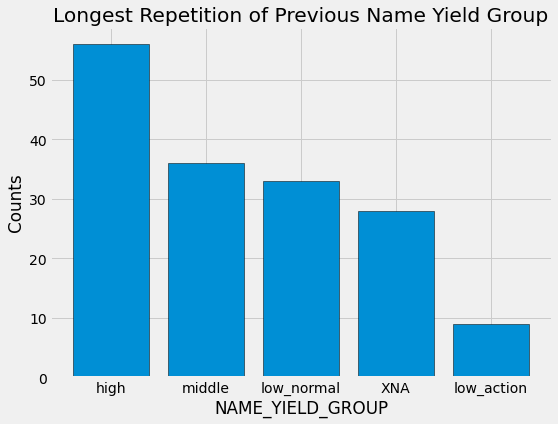

In [132]:
plt.figure(figsize = (8, 6))
plt.bar(custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts().index, custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts(), edgecolor = 'k')
plt.xlabel('NAME_YIELD_GROUP'); plt.ylabel('Counts'); plt.title('Longest Repetition of Previous Name Yield Group');

<AxesSubplot:xlabel='NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)', ylabel='Density'>

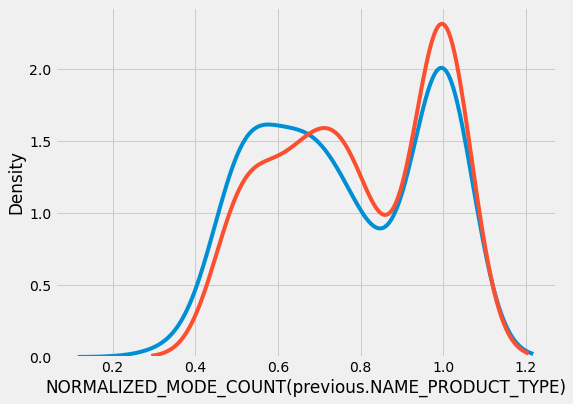

In [121]:
plt.figure(figsize = (8, 6))
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)'], label = 'NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)')
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)'], label = 'NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)')

これらの機能は完全に役に立たない場合もあれば、役立つ場合もあります。 モデルを構築し、機能を使用してトレーニングするだけで、答えを判断できます。

### MostRecent

最後のカスタム機能は`MOSTRECENT`になります。 これは、データフレームの時間列に関する離散変数の最新の値を返すだけです。 エンティティを作成すると、featuretoolsは `time_index`で[エンティティを並べ替え](https://github.com/Featuretools/featuretools/blob/master/featuretools/entityset/entity.py)します。 したがって、組み込みの集計プリミティブ `LAST`は、時間インデックスに基づいて最新の値を計算します。 ただし、複数の異なる時間列がある場合は、すべての時間に関する最新の値を知ることが役立つ場合があります。 カスタム機能プリミティブを構築するために、既存の `TREND`プリミティブ（[コードはこちら](https://github.com/Featuretools/featuretools/blob/master/featuretools/primitives/aggregation_primitives.py))を採用しました。

In [133]:
# Building on the Trend Aggregation Primitive
# Copied from https://github.com/Featuretools/featuretools/blob/master/featuretools/primitives/aggregation_primitives.py


#MostRecent = make_agg_primitive(function = most_recent,
#                                input_types = [Discrete, Datetime],
#                                return_type = Discrete)
class MostRecent(AggregationPrimitive):
    name = 'most_recent'
    input_types = [ColumnSchema(semantic_tags={'category'}), ColumnSchema(logical_type= Datetime)]
    return_type = ColumnSchema(semantic_tags={'category'})
    
    def get_function(self):
        def most_recent(y, x):
            df = pd.DataFrame({"x": x, "y": y}).dropna()

            if df.shape[0] < 1:
                return np.nan

            # Sort the values by timestamps reversed
            df = df.sort_values('x', ascending = False).reset_index()

            # Return the most recent occurence
            return df.iloc[0]['y']
        return most_recent

print('Create Functions')

Create Functions


In [134]:
# DFS with custom feature
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                            target_dataframe_name = 'app_train',
                                            agg_primitives = ['last', MostRecent],
                                            max_depth = 1,
                                            trans_primitives = [],
                                            features_only = False, verbose = True,
                                            chunk_size = len(app_train),
                                            ignore_dataframes = ['app_test'])

Built 271 features
Elapsed: 00:22 | Progress: 100%|██████████


To test whether this function works as intended, we can compare the most recent variable of `CREDIT_TYPE` ordered by two different dates. 

In [135]:
custom_features[['MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_end_date)', 'MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_application_date)']].head(10)

,"MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_end_date)","MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_application_date)"
SK_ID_CURR,,
100002,Consumer credit,Credit card
100003,Credit card,Credit card
100004,Consumer credit,Consumer credit
100006,NaN,NaN
100007,Consumer credit,Consumer credit
100008,Consumer credit,Consumer credit
100009,Consumer credit,Credit card
100010,Consumer credit,Consumer credit
100011,Credit card,Consumer credit


クライアント100002の場合、最新のクレジットの種類は、申し込み日までに注文した場合は「クレジットカード」でしたが、ローンの終了日までに注文した場合は「消費者クレジット」でした。 これが実際に役立つ知識であるかどうかはわかりません。

# Putting it all Together

最後に、時間変数、正しく指定されたカテゴリ変数、興味深い機能、シード機能、およびカスタム機能を使用して、詳細な機能合成を実行できます。 これをデータセット全体で実際に実行するには、ここでコードを取得し、スクリプトに入れてから、より多くの計算リソースを使用します。

In [136]:
late_payment

<Feature: late_payment>

In [137]:
past_due

<Feature: past_due>

In [138]:
# Run and create the features
feature_matrix, feature_names = ft.dfs(entityset = es
                                       ,target_dataframe_name = 'app_train'
                                       ,agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                         'sum', 'percent_true', NormalizedModeCount, MostRecent, LongestSeq]
                                       #,agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count'
                                       #                   ,'sum', 'percent_true', MostRecent, LongestSeq]
                                       ,trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile']
                                       ,where_primitives = ['mean', 'sum']
                                       ,seed_features = [late_payment, past_due]
                                       ,max_depth = 2
                                       ,features_only = False
                                       ,verbose = True
                                       ,chunk_size = len(app_train)
                                       ,ignore_dataframes = ['app_test'])

Built 3730 features
Elapsed: 01:27 | Progress: 100%|██████████


ここで、テストセットに適用されたのと同じ操作を実行します。 計算を個別に行うことで、テストデータからトレーニングデータへの漏洩を防ぐことができます。

In [140]:
# Run and create the features
feature_matrix_test, feature_names_test = ft.dfs(entityset = es
                                                 ,target_dataframe_name = 'app_test'
                                                #,agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                #                  'sum', 'percent_true', NormalizedModeCount, MostRecent, LongestSeq],
                                                ,agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                                'sum', 'percent_true', MostRecent, LongestSeq]
                                                ,trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile']
                                                ,where_primitives = ['mean', 'sum']
                                                ,seed_features = [late_payment, past_due]
                                                ,max_depth = 2
                                                ,features_only = False
                                                ,verbose = True
                                                ,chunk_size = len(app_test)
                                                ,ignore_dataframes = ['app_train'])

Built 3729 features
Elapsed: 00:24 | Progress: 100%|██████████


In [141]:
import random
random.sample(feature_names, 10)

[<Feature: LONGEST_REPETITION(installments.previous.CODE_REJECT_REASON)>,
 <Feature: PERCENTILE(MIN(credit.AMT_DRAWINGS_POS_CURRENT))>,
 <Feature: MIN(previous.CUM_MEAN(AMT_GOODS_PRICE))>,
 <Feature: SUM(previous.MIN(credit.AMT_DRAWINGS_OTHER_CURRENT))>,
 <Feature: MEAN(previous.MAX(credit.AMT_DRAWINGS_ATM_CURRENT))>,
 <Feature: MOST_RECENT(previous.MOST_RECENT(credit.NAME_CONTRACT_STATUS, credit_balance_date), previous_termination_date)>,
 <Feature: MIN(bureau.CUM_MEAN(AMT_ANNUITY))>,
 <Feature: MIN(cash.previous.RATE_DOWN_PAYMENT)>,
 <Feature: MIN(bureau.DIFF(AMT_ANNUITY))>,
 <Feature: MEAN(previous.PERCENTILE(RATE_INTEREST_PRIMARY))>]

## Remove Features

[特徴選択](https://en.wikipedia.org/wiki/Feature_selection)はそれ自体がトピック全体です。 ただし、できることの1つは、組み込みのfeaturetools [削除する選択関数](https://docs.featuretools.com/generated/featuretools.selection.remove_low_information_features.html)列を使用することです。この列には、一意の値が1つしかないか、 すべてのnull値。

In [142]:
from featuretools import selection

# Remove low information features
feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print('Removed %d features from training features'  % (feature_matrix.shape[1] - feature_matrix2.shape[1]))

feature_matrix_test2 = selection.remove_low_information_features(feature_matrix_test)
print('Removed %d features from testing features' % (feature_matrix_test.shape[1] - feature_matrix_test2.shape[1]))

Removed 329 features from training features
Removed 371 features from testing features


完了したら、結果をcsvに保存することをお勧めします。 データフレームのインデックスは識別列であるため、注意が必要です。そのため、インデックスを保持する必要があります。 また、トレーニングとテストのデータフレームを調整して、同じ列があることを確認する必要があります。

In [143]:
train_labels = feature_matrix['TARGET']
feature_matrix, feature_matrix_test = feature_matrix2.align(feature_matrix_test2, join = 'inner', axis = 1)
feature_matrix['TARGET'] = train_labels

print('Final training shape: ', feature_matrix.shape)
print('Final testing shape: ', feature_matrix_test.shape)

Final training shape:  (1001, 3359)
Final testing shape:  (1001, 3358)


In [144]:
# Save the feature matrix to a csv
feature_matrix.to_csv('feature_matrix.csv')
feature_matrix_test.to_csv('feature_matrix_test.csv')

# Conclusions 

このノートブックでは、次のような機能ツールの高度な機能のいくつかについて説明しました。

* 時間変数：時間の経過に伴う傾向を追跡できます
* 興味深い変数：既存の機能の値に基づいて新しい機能を調整します
* シード機能：featuretoolsがその上に構築する新しい機能を手動で定義します
* カスタム機能プリミティブ：ドメイン知識を組み込むことができる変換または集約機能を設計する

これらの方法を使用して、問題に関するドメイン知識を機能にエンコードしたり、他の人が有用だと思ったものに基づいて機能を作成したりできます。ここからの次のステップは、データセット全体でスクリプトを実行してから、モデリングに機能を使用することです。モデルの特徴の重要度を使用して、最も関連性の高い特徴を決定し、特徴選択を実行してから、プリミティブ、シード特徴、および興味深い特徴の新しいセットを使用して、特徴合成の別のラウンドを実行できます。機械学習の多くの側面と同様に、機能の作成は主に経験的で反復的な手順です。